In [4]:
# notebooky stuff
%load_ext autoreload
%autoreload 2
from IPython.display import display

import sys 
sys.path.append('../../modules')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import eumf_data, eumf_eval, eumf_pipeline, eumf_custom_models
from sklearn import dummy, preprocessing, linear_model, svm, model_selection, ensemble, gaussian_process
import seaborn as sns
from tqdm import tqdm
import statsmodels.api as sm
import xgboost as xgb
import json


# pandas pretty output
pd.set_option('display.min_rows', 20)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load all data

In [2]:
# list of countries
countries = eumf_data.get_countries()
countries.remove("CY")

# migration rates
df_values = eumf_data.load_registrations_from_csv(impute_missing=True, countries=countries)

# google trends
df_trends = eumf_data.load_trends_from_csv(countries=countries)
keyword_ids = df_trends.columns.levels[0].tolist()

# macroeconomic data
df_gdp = eumf_data.read_gdp(countries=countries)
df_unempl = eumf_data.read_unempl(countries=countries)

country_combinations = [
    # ["GR", "CY"],
    ["LV", "LT", "EE"],
    ["BE", "NL", "LU"],
    ["CZ", "SK"],
    ["SE", "FI", "DK"],
    ["AT", "CH"]
]

panel = df_values.join(df_trends, how="outer")
panel_3m = panel.resample("3M", closed="left").mean()

panel_comb = eumf_data.combine_countries(panel, combinations=country_combinations)
panel_comb_3m = eumf_data.combine_countries(panel_3m, combinations=country_combinations)
df_gdp_comb = eumf_data.combine_countries(df_gdp, combinations=country_combinations)
df_unempl_comb = eumf_data.combine_countries(
    df_unempl, combinations=country_combinations, average=True
)
# note: strictly, unweighted average is wrong for unemployment, but should work in most cases

panel_comb_3m_macro = panel_comb_3m.join(df_gdp_comb).join(df_unempl_comb)

panel_comb_3m_macro["2017":"2018"]


/home/stei509/eu_migration_forecast/notebooks/final_paper/../../modules/eumf_data.py:238: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index)
/home/stei509/eu_migration_forecast/notebooks/final_paper/../../modules/eumf_data.py:279: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index)


10                                                                                                                       11                                                                                                                                            112                                                                                                               ...   value                                                                                                                                     gdp                                                                                                                                                unempl                                                                                                      
            AT+CH  BE+NL+LU  BG  CZ+SK    ES      FR      GB    GR   HR   HU   IE     IT   LV+LT+EE    PL    PT   RO  SE+FI+DK  SI   AT+CH  BE+NL+LU    BG    CZ+SK     ES      FR      GB      GR     HR      HU      IE      IT   LV+LT+EE    PL      PT      RO   SE+FI+DK  SI   AT+CH  BE+NL+LU    BG    CZ+SK      ES      FR      GB      GR      HR      HU      IE      IT   LV+LT+EE    PL    ...     ES        FR        GB        GR        HR        HU       IE        IT     LV+LT+EE     PL        PT        RO     SE+FI+DK    SI     AT+CH   BE+NL+LU    BG    CZ+SK     ES      FR      GB      GR      HR      HU      IE       IT   LV+LT+EE    PL      PT      RO   SE+FI+DK    SI   AT+CH  BE+NL+LU  BG  CZ+SK   ES   FR   GB    GR    HR   HU   IE    IT  LV+LT+EE  PL   PT   RO  SE+FI+DK  SI 
date                                                                                                                                                                                                                                                                                                                                                                                                   ...                                                                                                                                                                                                                                                                                                                                                                                                            
2017-03-31  10.524  16.048   0.0   0.0  26.667  21.857  21.381  0.0  0.0  0.0  0.0  14.095    0.0     6.095  0.0  0.0  21.286   0.0  34.714  60.190    2.190  10.857  38.714  29.810  53.381  10.000  0.000   0.619  11.095  22.048    0.0    11.952  12.714  11.571  26.524   0.0  97.190  178.952  42.238  127.048  33.143  63.333  47.286   9.000  63.095  62.810  59.333  14.905  179.429  39.524  ...  1689.000  1268.333  1080.333  2327.333  4459.000  3747.667  156.000  5255.333  1396.333  12264.667  866.333  18186.333  654.333  420.333  28780.0  42970.0  1510.0  7620.0  5950.0  8450.0  9080.0  3760.0  2590.0  2820.0  14640.0  6800.0  10490.0  2760.0  4520.0  1850.0  33780.0  4790.0  2.85    6.433   6.6  6.00  18.2  9.6  4.6  22.4  12.7  4.3  7.4  11.6   7.333   5.3  9.8  5.3   7.167   7.4
2017-06-30   4.952  14.810   0.0   0.0  21.048  13.952  18.857  0.0  0.0  0.0  0.0  15.286    0.0     6.524  0.0  0.0  27.714   0.0  39.286  61.619   10.619   7.714  24.381  27.952  55.714   4.714  2.333   7.095  20.619  17.286    0.0    13.810  23.143  11.143  32.857   0.0  85.619  168.905  35.190   83.429  23.810  57.857  48.000  11.905  33.048  27.905  62.810  14.286  126.667  21.476  ...  1427.667  1023.333  1049.000  2113.333  4121.333  3637.667  164.667  4699.000  1407.000  12940.000  609.667  19264.000  520.333  365.000  29250.0  44540.0  1800.0  8470.0  6330.0  8560.0  8980.0  4120.0  2990.0  3200.0  14700.0  7140.0  11780.0  2960.0  4790.0  2200.0  35590.0  5260.0  2.70    5.867   6.2  5.75  17.3  9.6  4.4  21.8  11.5  4.3  6.7  11.3   7.667   5.1  9.2  4.9   7.133   6.6
2017-09-30   4.905  16.095   0.0   0.0  12.429  21.048  16.

## Global definitions

In [104]:
T_MIN = "2010"
T_MAX = "2019"

T_TEST_MIN = "2019"
T_TEST_MAX = "2019"

cv_default = eumf_eval.BlockKFold(n_splits=8, margin=1.0)
cv_random = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
# n_countries = len(panel_comb_3m_macro["value"].columns)
# cv_time = model_selection.TimeSeriesSplit(test_size=4 * n_countries, n_splits=6)

cv_scores_global, test_scores_global = [], []

with open("best_feature_combinations.json") as f:
    best_feature_combinations = json.load(f)

selected_keyword_ids = [
    "19",
    "118",
    "28",
    "24",
    "123",
    "119",
    "39",
    "115",
    "124",
    "117",
]

lags_default = [1, 2, 3, 4, 5, 6, 7, 8]
alternate_lags_default = {
    "value": [2, 3, 4, 5, 6, 7, 8],
    "gdp": [2, 3, 4, 5, 6, 7, 8],
    "unempl": [2, 3, 4, 5, 6, 7, 8],
}

features = ["value", "gdp", "unempl"] + selected_keyword_ids



## Best models

### Best ensemble

Random forest

In [10]:
### TRAINING

# rough tuning already performed, this is the final search space
params = {
    "randomforestregressor__max_features": [None],
    "randomforestregressor__min_samples_leaf": [4, 6, 8, 10, 12],
    "randomforestregressor__min_samples_split": [2, 4, 8],
}

labeled = eumf_pipeline.prepare_data(
    panel_comb_3m_macro,
    columns=features,
    lags=lags_default,
    alternate_lags=alternate_lags_default,
    t_min=T_MIN,
    t_max=T_MAX,
)

labeled.x = labeled.x[best_feature_combinations["ensemble"]["all"]]
transformed = eumf_pipeline.transform_data(labeled)
train, test = eumf_pipeline.split_data(
    transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
)
train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)


tuner = eumf_pipeline.train_reg_model(
    train_stacked,
    reg=ensemble.RandomForestRegressor(random_state=42),
    extra_pipeline_steps=[preprocessing.StandardScaler()],
    params=params,
    scoring=eumf_eval.scorer_mae,
    cv=cv_default,
    random_iterations=20,
)

cv_score = eumf_eval.score_cv(
    tuner.best_estimator_,
    train_stacked,
    cv=cv_default,
)

test_score = eumf_eval.score_test(
    tuner.best_estimator_,
    test_stacked,
)


/home/stei509/eu_migration_forecast/.venv/lib/python3.10/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 15 is smaller than n_iter=20. Running 15 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [11]:
pd.DataFrame(tuner.cv_results_).sort_values("rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestregressor__min_samples_split,param_randomforestregressor__min_samples_leaf,param_randomforestregressor__max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score,std_test_score,rank_test_score
9,2.219,0.531,0.034,0.009,2,10,None,{'randomforestregressor__min_samples_split': 2...,-0.115,-0.093,-0.088,-0.111,-0.060,-0.084,-0.059,-0.047,-0.082,0.023,1
10,2.765,0.275,0.037,0.016,4,10,None,{'randomforestregressor__min_samples_split': 4...,-0.115,-0.093,-0.088,-0.111,-0.060,-0.084,-0.059,-0.047,-0.082,0.023,1
11,2.282,0.187,0.036,0.007,8,10,None,{'randomforestregressor__min_samples_split': 8...,-0.115,-0.093,-0.088,-0.111,-0.060,-0.084,-0.059,-0.047,-0.082,0.023,1
6,2.529,0.385,0.038,0.010,2,8,None,{'randomforestregressor__min_samples_split': 2...,-0.117,-0.097,-0.088,-0.109,-0.059,-0.084,-0.059,-0.046,-0.083,0.024,4
7,2.717,0.594,0.044,0.019,4,8,None,{'randomforestregressor__min_samples_split': 4...,-0.117,-0.097,-0.088,-0.109,-0.059,-0.084,-0.059,-0.046,-0.083,0.024,4
8,2.746,0.397,0.035,0.009,8,8,None,{'randomforestregressor__min_samples_split': 8...,-0.117,-0.097,-0.088,-0.109,-0.059,-0.084,-0.059,-0.046,-0.083,0.024,4
12,2.541,0.281,0.035,0.012,2,12,None,{'randomforestregressor__min_samples_split': 2...,-0.120,-0.092,-0.089,-0.111,-0.060,-0.083,-0.059,-0.047,-0.083,0.024,7
13,2.792,0.450,0.054,0.020,4,12,None,{'randomforestregressor__min_samples_split': 4...,-0.120,-0.092,-0.089,-0.111,-0.060,-0.083,-0.059,-0.047,-0.083,0.024,7
14,2.202,0.189,0.030,0.014,8,12,None,{'randomforestregressor__min_samples_split': 8...,-0.120,-0.092,-0.089,-0.111,-0.060,-0.083,-0.059,-0.047,-0.083,0.024,7
3,2.245,0.146,0.028,0.003,2,6,None,{'randomforestregressor__min_samples_split': 2...,-0.123,-0.095,-0.088,-0.107,-0.059,-0.086,-0.060,-0.046,-0.083,0.025,10


XGBoost

In [47]:
### TRAINING

# rough tuning already performed, this is the final search space
params = {
    "xgbregressor__eta": np.linspace(0.05, 0.3, 50),
    "xgbregressor__max_depth": [6, 7, 8, 9, 10],
    "xgbregressor__min_child_weight": [2, 4],
    "xgbregressor__max_delta_step": [2, 3, 4, 5, 6, 7, 8],
    "xgbregressor__subsample":  np.linspace(0.6, 0.75, 50),
    "xgbregressor__colsample_bytree": np.linspace(0.7, 0.9, 50),
    "xgbregressor__colsample_bylevel": np.linspace(0.8, 1.0, 50),
    "xgbregressor__colsample_bynode": np.linspace(0.6, 1.0, 50),
    "xgbregressor__lambda": np.linspace(0.8, 0.95, 50),
    "xgbregressor__alpha": np.linspace(0.75,0.95),
}


labeled = eumf_pipeline.prepare_data(
    panel_comb_3m_macro,
    columns=features,
    lags=lags_default,
    alternate_lags=alternate_lags_default,
    t_min=T_MIN,
    t_max=T_MAX,
)

labeled.x = labeled.x[best_feature_combinations["ensemble"]["all"]]
transformed = eumf_pipeline.transform_data(labeled)
train, test = eumf_pipeline.split_data(
    transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
)
train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)


tuner = eumf_pipeline.train_reg_model(
    train_stacked,
    reg=xgb.XGBRegressor(random_state=42),
    extra_pipeline_steps=[preprocessing.StandardScaler()],
    params=params,
    scoring=eumf_eval.scorer_mae,
    cv=cv_default,
    random_iterations=20,
)

cv_score = eumf_eval.score_cv(
    tuner.best_estimator_,
    train_stacked,
    cv=cv_default,
)

test_score = eumf_eval.score_test(
    tuner.best_estimator_,
    test_stacked,
)


In [48]:
pd.DataFrame(tuner.cv_results_).sort_values("rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgbregressor__subsample,param_xgbregressor__min_child_weight,param_xgbregressor__max_depth,param_xgbregressor__max_delta_step,param_xgbregressor__lambda,param_xgbregressor__eta,param_xgbregressor__colsample_bytree,param_xgbregressor__colsample_bynode,param_xgbregressor__colsample_bylevel,param_xgbregressor__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score,std_test_score,rank_test_score
8,1.040,0.079,0.022,0.004,0.661,4,9,8,0.84,0.076,0.737,0.902,0.841,0.864,{'xgbregressor__subsample': 0.6612244897959183...,-0.125,-0.105,-0.095,-0.103,-0.056,-0.080,-0.065,-0.052,-0.085,0.024,1
9,0.841,0.122,0.022,0.008,0.686,4,6,8,0.831,0.081,0.798,0.665,0.98,0.819,{'xgbregressor__subsample': 0.6857142857142857...,-0.128,-0.106,-0.095,-0.103,-0.056,-0.082,-0.064,-0.053,-0.086,0.025,2
4,0.574,0.062,0.017,0.008,0.624,4,7,7,0.864,0.065,0.708,0.641,0.869,0.877,{'xgbregressor__subsample': 0.6244897959183673...,-0.125,-0.102,-0.097,-0.108,-0.054,-0.082,-0.069,-0.052,-0.086,0.025,3
15,0.694,0.066,0.013,0.002,0.744,4,9,7,0.907,0.172,0.704,0.698,0.951,0.783,{'xgbregressor__subsample': 0.7438775510204081...,-0.136,-0.092,-0.106,-0.101,-0.062,-0.075,-0.064,-0.054,-0.086,0.026,4
5,0.478,0.039,0.013,0.002,0.664,4,9,8,0.91,0.244,0.712,0.665,0.996,0.889,{'xgbregressor__subsample': 0.6642857142857143...,-0.119,-0.097,-0.103,-0.113,-0.059,-0.077,-0.069,-0.056,-0.087,0.023,5
17,0.645,0.132,0.019,0.006,0.695,4,10,7,0.84,0.121,0.745,0.633,0.918,0.881,{'xgbregressor__subsample': 0.6948979591836735...,-0.129,-0.096,-0.098,-0.110,-0.060,-0.078,-0.068,-0.054,-0.087,0.024,6
0,0.699,0.149,0.022,0.002,0.634,2,6,2,0.91,0.137,0.712,0.714,0.922,0.868,"{'xgbregressor__subsample': 0.633673469387755,...",-0.132,-0.110,-0.098,-0.105,-0.059,-0.077,-0.061,-0.055,-0.087,0.026,7
12,1.299,0.169,0.021,0.005,0.738,4,7,6,0.889,0.116,0.835,0.976,0.988,0.872,{'xgbregressor__subsample': 0.7377551020408163...,-0.128,-0.106,-0.096,-0.101,-0.062,-0.081,-0.070,-0.055,-0.087,0.023,8
14,0.627,0.070,0.022,0.010,0.713,4,7,8,0.84,0.076,0.9,0.657,0.886,0.856,"{'xgbregressor__subsample': 0.713265306122449,...",-0.129,-0.105,-0.096,-0.115,-0.057,-0.084,-0.066,-0.050,-0.088,0.027,9
7,1.245,0.254,0.029,0.008,0.646,2,7,8,0.864,0.157,0.896,0.984,0.812,0.828,{'xgbregressor__subsample': 0.6459183673469387...,-0.131,-0.098,-0.106,-0.108,-0.064,-0.077,-0.071,-0.050,-0.088,0.025,10


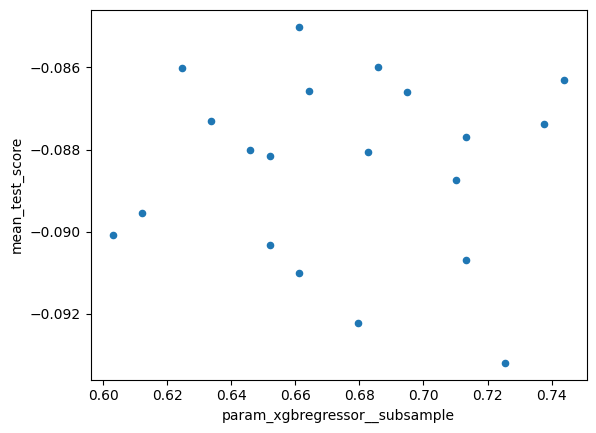

In [49]:
hyperparams = pd.DataFrame(tuner.cv_results_).sort_values("rank_test_score")
hyperparams.plot.scatter("param_xgbregressor__subsample", "mean_test_score")
plt.show()

AdaBoost

In [56]:
### TRAINING

# rough tuning already performed, this is the final search space
params = {
    "adaboostregressor__learning_rate": np.linspace(0.5, 1.5, 11),
    "adaboostregressor__loss": ["linear", "square", "exponential"],
}


labeled = eumf_pipeline.prepare_data(
    panel_comb_3m_macro,
    columns=features,
    lags=lags_default,
    alternate_lags=alternate_lags_default,
    t_min=T_MIN,
    t_max=T_MAX,
)

labeled.x = labeled.x[best_feature_combinations["ensemble"]["all"]]
transformed = eumf_pipeline.transform_data(labeled)
train, test = eumf_pipeline.split_data(
    transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
)
train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)


tuner = eumf_pipeline.train_reg_model(
    train_stacked,
    reg=ensemble.AdaBoostRegressor(random_state=42, n_estimators=100),
    extra_pipeline_steps=[preprocessing.StandardScaler()],
    params=params,
    scoring=eumf_eval.scorer_mae,
    cv=cv_default,
)

cv_score = eumf_eval.score_cv(
    tuner.best_estimator_,
    train_stacked,
    cv=cv_default,
)

test_score = eumf_eval.score_test(
    tuner.best_estimator_,
    test_stacked,
)


In [57]:
pd.DataFrame(tuner.cv_results_).sort_values("rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_adaboostregressor__learning_rate,param_adaboostregressor__loss,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score,std_test_score,rank_test_score
5,2.088,0.364,0.104,0.060,0.6,exponential,"{'adaboostregressor__learning_rate': 0.6, 'ada...",-0.148,-0.094,-0.097,-0.119,-0.061,-0.087,-0.062,-0.052,-0.090,0.030,1
0,2.084,0.389,0.145,0.041,0.5,linear,"{'adaboostregressor__learning_rate': 0.5, 'ada...",-0.149,-0.092,-0.098,-0.116,-0.063,-0.088,-0.066,-0.052,-0.091,0.030,2
2,1.771,0.408,0.099,0.063,0.5,exponential,"{'adaboostregressor__learning_rate': 0.5, 'ada...",-0.149,-0.094,-0.102,-0.117,-0.061,-0.087,-0.066,-0.051,-0.091,0.030,3
8,1.933,0.336,0.111,0.037,0.7,exponential,"{'adaboostregressor__learning_rate': 0.7, 'ada...",-0.150,-0.094,-0.099,-0.121,-0.062,-0.087,-0.061,-0.055,-0.091,0.031,4
23,1.635,0.232,0.066,0.014,1.2,exponential,{'adaboostregressor__learning_rate': 1.2000000...,-0.141,-0.097,-0.097,-0.122,-0.060,-0.090,-0.064,-0.059,-0.091,0.028,5
3,2.197,0.247,0.106,0.085,0.6,linear,"{'adaboostregressor__learning_rate': 0.6, 'ada...",-0.148,-0.094,-0.100,-0.118,-0.060,-0.090,-0.068,-0.053,-0.091,0.030,6
18,1.384,0.140,0.062,0.009,1.1,linear,"{'adaboostregressor__learning_rate': 1.1, 'ada...",-0.147,-0.095,-0.105,-0.112,-0.060,-0.089,-0.066,-0.058,-0.091,0.028,7
30,1.363,0.132,0.062,0.010,1.5,linear,"{'adaboostregressor__learning_rate': 1.5, 'ada...",-0.144,-0.095,-0.102,-0.117,-0.060,-0.089,-0.067,-0.058,-0.091,0.028,8
20,2.047,0.252,0.082,0.023,1.1,exponential,"{'adaboostregressor__learning_rate': 1.1, 'ada...",-0.151,-0.093,-0.100,-0.117,-0.061,-0.090,-0.066,-0.055,-0.091,0.030,9
11,1.708,0.163,0.085,0.034,0.8,exponential,"{'adaboostregressor__learning_rate': 0.8, 'ada...",-0.148,-0.092,-0.104,-0.121,-0.059,-0.091,-0.063,-0.053,-0.091,0.031,10


include country variables (aka "fixed effects") in random forest?

In [58]:
### TRAINING

fixed_effects = [True, False]
model_names = ["rf_fe", "rf_no_fe"]

models = [
    ensemble.RandomForestRegressor(random_state=42),
    ensemble.RandomForestRegressor(random_state=42),
]


tuners, estimators = [], []
cv_scores, test_scores = [], []
train_stackeds, test_stackeds, train_unstackeds = [], [], []

params = {}

for i, name in enumerate(tqdm(model_names)):
    labeled = eumf_pipeline.prepare_data(
        panel_comb_3m_macro,
        columns=features,
        lags=lags_default,
        alternate_lags=alternate_lags_default,
        t_min=T_MIN,
        t_max=T_MAX,
    )
    transformed = eumf_pipeline.transform_data(labeled)
    train, test = eumf_pipeline.split_data(
        transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
    )
    train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)

    train_stackeds.append(train_stacked)
    train_unstackeds.append(train)
    test_stackeds.append(test_stacked)

    tuner = eumf_pipeline.train_reg_model(
        train_stacked,
        reg=models[i],
        extra_pipeline_steps=[preprocessing.StandardScaler()],
        params=params,
        scoring=eumf_eval.scorer_mae,
        cv=cv_default,
        # cv=cv_default,
        dummy_encoder=preprocessing.OneHotEncoder() if fixed_effects else "drop",
    )
    estimator = tuner.best_estimator_
    tuners.append(tuner)
    estimators.append(estimator)

    cv_score = eumf_eval.score_cv(
        estimator, train_stacked, cv=cv_default, return_train_score=True
    )
    cv_scores.append(cv_score)

    test_score = eumf_eval.score_test(
        estimator,
        test_stacked,
    )
    test_scores.append(test_score)


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [01:09<00:00, 34.80s/it]


In [59]:
eumf_eval.agg_multiple_cv_scores(cv_scores, model_names)


fit_time               score_time               test_mae               train_mae                   test_rmse              train_rmse               test_explained_variance               train_explained_variance               test_r2_mod               train_r2_mod               test_delta_mae               train_delta_mae              
           mean    std    sem      mean     std    sem     mean    std    sem      mean    std      sem        mean    std   sem      mean     std    sem             mean           std    sem             mean            std    sem       mean     std    sem       mean      std    sem        mean       std    sem         mean       std    sem  
rf_fe      2.501   0.217  0.077    0.016    0.003  0.001  -0.088   0.031  0.011   -0.028   0.002  6.457e-04   -0.126   0.05  0.018   -0.044    0.004  0.001           0.292          0.189  0.067           0.944           0.004  0.001     0.395    0.237  0.084     0.951     0.005  0.002      0.039      0.044  0.016       0.101      0.016  0.006
rf_no_fe   2.565   0.343  0.121    0.017    0.003  0.001  -0.088   0.031  0.011   -0.028   0.002  6.457e-04   -0.126   0.05  0.018   -0.044    0.004  0.001           0.292          0.189  0.067           0.944           0.004  0.001     0.395    0.237  0.084     0.951     0.005  0.002      0.039      0.044  0.016       0.101      0.016  0.006

### Best linear models

compare

In [64]:
### TRAINING

model_names = [
    "linreg",
    "elasticnet",
    "sgd",
    "ard",
    "bayesian",
    "huber",
    "theil",
]



models = [
    linear_model.LinearRegression(),
    linear_model.ElasticNetCV(),
    linear_model.SGDRegressor(),
    linear_model.ARDRegression(),
    linear_model.BayesianRidge(),
    linear_model.HuberRegressor(),
    linear_model.TheilSenRegressor(),
]


tuners, estimators = [], []
cv_scores, test_scores = [], []
train_stackeds, test_stackeds, train_unstackeds = [], [], []

params = {}

for i, name in enumerate(tqdm(model_names)):
    labeled = eumf_pipeline.prepare_data(
        panel_comb_3m_macro,
        columns=features,
        lags=lags_default,
        alternate_lags=alternate_lags_default,
        t_min=T_MIN,
        t_max=T_MAX,
    )
    labeled.x = labeled.x[best_feature_combinations["linear"]["all"]]
    transformed = eumf_pipeline.transform_data(labeled)
    train, test = eumf_pipeline.split_data(
        transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
    )
    train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)

    train_stackeds.append(train_stacked)
    train_unstackeds.append(train)
    test_stackeds.append(test_stacked)

    tuner = eumf_pipeline.train_reg_model(
        train_stacked,
        reg=models[i],
        extra_pipeline_steps=[preprocessing.StandardScaler()],
        params=params,
        scoring=eumf_eval.scorer_mae,
        cv=cv_default,
        # cv=cv_default,
        dummy_encoder="drop",
    )
    estimator = tuner.best_estimator_
    tuners.append(tuner)
    estimators.append(estimator)

    cv_score = eumf_eval.score_cv(
        estimator, train_stacked, cv=cv_default, return_train_score=True
    )
    cv_scores.append(cv_score)

    test_score = eumf_eval.score_test(
        estimator,
        test_stacked,
    )
    test_scores.append(test_score)


  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:37<00:00,  5.34s/it]


In [65]:
eumf_eval.agg_multiple_cv_scores(cv_scores, model_names)


fit_time                   score_time                   test_mae               train_mae               test_rmse               train_rmse               test_explained_variance               train_explained_variance               test_r2_mod               train_r2_mod               test_delta_mae               train_delta_mae              
             mean    std      sem        mean     std      sem       mean    std    sem      mean    std    sem      mean    std    sem      mean     std    sem             mean           std    sem             mean            std    sem       mean     std    sem       mean      std    sem        mean       std    sem         mean       std    sem  
linreg       0.047   0.037  1.297e-02    0.025    0.017  5.945e-03  -0.072   0.018  0.006   -0.069   0.004  0.001   -0.110   0.039  0.014   -0.104    0.009  0.003           0.371          0.224  0.079           0.688           0.034  0.012     0.498    0.254  0.090     0.730     0.045  0.016      0.054      0.056  0.020       0.060      0.014  0.005
elasticnet   0.373   0.078  2.766e-02    0.019    0.009  3.263e-03  -0.072   0.018  0.006   -0.069   0.004  0.001   -0.110   0.039  0.014   -0.104    0.009  0.003           0.377          0.216  0.076           0.688           0.035  0.012     0.502    0.245  0.087     0.729     0.045  0.016      0.055      0.056  0.020       0.060      0.014  0.005
sgd          0.011   0.002  7.336e-04    0.009    0.001  4.349e-04  -0.076   0.020  0.007   -0.072   0.004  0.002   -0.114   0.041  0.015   -0.107    0.009  0.003           0.350          0.206  0.073           0.667           0.035  0.012     0.475    0.253  0.089     0.711     0.046  0.016      0.051      0.056  0.020       0.057      0.014  0.005
ard          0.038   0.015  5.237e-03    0.010    0.002  6.023e-04  -0.074   0.018  0.006   -0.070   0.004  0.001   -0.111   0.041  0.014   -0.106    0.009  0.003           0.383          0.200  0.071           0.676           0.038  0.013     0.498    0.234  0.083     0.719     0.049  0.017      0.053      0.056  0.020       0.059      0.015  0.005
bayesian     0.044   0.008  2.835e-03    0.017    0.009  3.185e-03  -0.072   0.019  0.007   -0.069   0.004  0.001   -0.110   0.040  0.014   -0.104    0.009  0.003           0.382          0.208  0.074           0.685           0.035  0.012     0.506    0.237  0.084     0.727     0.045  0.016      0.054      0.056  0.020       0.060      0.014  0.005
huber        0.049   0.005  1.944e-03    0.010    0.001  4.665e-04  -0.071   0.020  0.007   -0.066   0.004  0.001   -0.107   0.040  0.014   -0.107    0.009  0.003           0.427          0.187  0.066           0.669           0.035  0.012     0.542    0.210  0.074     0.712     0.046  0.016      0.056      0.054  0.019       0.063      0.015  0.005
theil        1.959   0.189  6.679e-02    0.007    0.002  7.878e-04  -0.075   0.025  0.009   -0.069   0.004  0.001   -0.113   0.047  0.017   -0.110    0.008  0.003           0.414          0.175  0.062           0.652           0.031  0.011     0.518    0.194  0.069     0.696     0.045  0.016      0.051      0.048  0.017       0.061      0.014  0.005

pooled vs unpooled (no fixed effects)

In [70]:
### TRAINING

model_names = [
    "linreg_pooled",
    "linreg_unpooled",
]

pooled = [True, False]

models = [
    linear_model.HuberRegressor(),
    linear_model.HuberRegressor(),
]


tuners, estimators = [], []
cv_scores, test_scores = [], []
train_stackeds, test_stackeds, train_unstackeds = [], [], []

params = {}

for i, name in enumerate(tqdm(model_names)):
    labeled = eumf_pipeline.prepare_data(
        panel_comb_3m_macro,
        columns=features,
        lags=lags_default,
        alternate_lags=alternate_lags_default,
        t_min=T_MIN,
        t_max=T_MAX,
    )
    labeled.x = labeled.x[best_feature_combinations["linear"]["all"]]
    transformed = eumf_pipeline.transform_data(labeled)
    train, test = eumf_pipeline.split_data(
        transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
    )
    train_stacked, test_stacked = eumf_pipeline.stack_data(train, test, pooled=pooled[i])

    train_stackeds.append(train_stacked)
    train_unstackeds.append(train)
    test_stackeds.append(test_stacked)

    tuner = eumf_pipeline.train_reg_model(
        train_stacked,
        reg=models[i],
        extra_pipeline_steps=[preprocessing.StandardScaler()],
        params=params,
        scoring=eumf_eval.scorer_mae,
        cv=cv_default,
        # cv=cv_default,
        dummy_encoder="drop",
    )
    estimator = tuner.best_estimator_
    tuners.append(tuner)
    estimators.append(estimator)

    cv_score = eumf_eval.score_cv(
        estimator, train_stacked, cv=cv_default, return_train_score=True
    )
    cv_scores.append(cv_score)

    test_score = eumf_eval.score_test(
        estimator,
        test_stacked,
    )
    test_scores.append(test_score)


  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:01<00:01,  1.30s/it]/home/stei509/eu_migration_forecast/.venv/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/stei509/eu_migration_forecast/.venv/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/stei509/eu_migration_forecast/.venv/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: Conv

In [71]:
eumf_eval.agg_multiple_cv_scores(cv_scores, model_names)


fit_time               score_time                   test_mae               train_mae                   test_rmse               train_rmse               test_explained_variance               train_explained_variance               test_r2_mod               train_r2_mod               test_delta_mae               train_delta_mae              
                  mean    std    sem      mean     std      sem       mean    std    sem      mean    std      sem        mean    std    sem      mean     std    sem             mean           std    sem             mean            std    sem       mean     std    sem       mean      std    sem        mean       std    sem         mean       std    sem  
linreg_pooled     0.031   0.006  0.002    0.008    0.003  9.074e-04  -0.071   0.020  0.007   -0.066   0.004  1.302e-03   -0.107   0.040  0.014   -0.107    0.009  0.003           0.427          0.187  0.066           0.669           0.035  0.012     0.542    0.210  0.074     0.712     0.046  0.016      0.056      0.054  0.019       0.063      0.015  0.005
linreg_unpooled   0.592   0.339  0.120    0.019    0.007  2.493e-03  -0.149   0.053  0.019   -0.010   0.002  6.106e-04   -0.205   0.078  0.027   -0.029    0.004  0.002          -1.321          1.236  0.437           0.975           0.008  0.003    -0.862    1.274  0.450     0.978     0.008  0.003     -0.022      0.033  0.012       0.119      0.018  0.006

fixed v no fixed effects

In [76]:
### TRAINING

model_names = [
    "linreg_fe",
    "linreg_no_fe",
]

fixed = [True, False]


models = [
    linear_model.HuberRegressor(),
    linear_model.HuberRegressor(),
]


tuners, estimators = [], []
cv_scores, test_scores = [], []
train_stackeds, test_stackeds, train_unstackeds = [], [], []

params = {}

for i, name in enumerate(tqdm(model_names)):
    labeled = eumf_pipeline.prepare_data(
        panel_comb_3m_macro,
        columns=features,
        lags=lags_default,
        alternate_lags=alternate_lags_default,
        t_min=T_MIN,
        t_max=T_MAX,
    )
    labeled.x = labeled.x[best_feature_combinations["linear"]["all"]]
    transformed = eumf_pipeline.transform_data(labeled)
    train, test = eumf_pipeline.split_data(
        transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
    )
    train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)

    train_stackeds.append(train_stacked)
    train_unstackeds.append(train)
    test_stackeds.append(test_stacked)

    tuner = eumf_pipeline.train_reg_model(
        train_stacked,
        reg=models[i],
        extra_pipeline_steps=[preprocessing.StandardScaler()],
        params=params,
        scoring=eumf_eval.scorer_mae,
        cv=cv_default,
        # cv=cv_default,
        dummy_encoder=preprocessing.OneHotEncoder() if fixed[i] else "drop",
    )
    estimator = tuner.best_estimator_
    tuners.append(tuner)
    estimators.append(estimator)

    cv_score = eumf_eval.score_cv(
        estimator, train_stacked, cv=cv_default, return_train_score=True
    )
    cv_scores.append(cv_score)

    test_score = eumf_eval.score_test(
        estimator,
        test_stacked,
    )
    test_scores.append(test_score)


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:07<00:00,  3.51s/it]


In [77]:
eumf_eval.agg_multiple_cv_scores(cv_scores, model_names)


fit_time               score_time                   test_mae               train_mae               test_rmse               train_rmse               test_explained_variance               train_explained_variance               test_r2_mod               train_r2_mod               test_delta_mae               train_delta_mae              
               mean    std    sem      mean     std      sem       mean    std    sem      mean    std    sem      mean    std    sem      mean     std    sem             mean           std    sem             mean            std    sem       mean     std    sem       mean      std    sem        mean       std    sem         mean       std    sem  
linreg_fe      0.240   0.253  0.089    0.018    0.003  9.504e-04  -0.074   0.021  0.008   -0.064   0.004  0.002   -0.111   0.043  0.015   -0.106    0.009  0.003           0.380          0.205  0.072           0.679           0.026  0.009     0.512    0.215  0.076     0.720     0.037  0.013      0.052      0.051  0.018       0.066      0.014  0.005
linreg_no_fe   0.139   0.082  0.029    0.014    0.003  1.135e-03  -0.071   0.020  0.007   -0.066   0.004  0.001   -0.107   0.040  0.014   -0.107    0.009  0.003           0.427          0.187  0.066           0.669           0.035  0.012     0.542    0.210  0.074     0.712     0.046  0.016      0.056      0.054  0.019       0.063      0.015  0.005

### Alternative: Gaussian Process Estimation

In [78]:
### TRAINING

model_names = [
    "gp",
    "gp_norm",
]

kernel = gaussian_process.kernels.DotProduct() + gaussian_process.kernels.WhiteKernel()
gaussian_process.GaussianProcessRegressor(kernel=kernel, random_state=42)

models = [
    gaussian_process.GaussianProcessRegressor(kernel=kernel, random_state=42),
    gaussian_process.GaussianProcessRegressor(kernel=kernel, random_state=42, normalize_y=True),
]


tuners, estimators = [], []
cv_scores, test_scores = [], []
train_stackeds, test_stackeds, train_unstackeds = [], [], []

params = {}

for i, name in enumerate(tqdm(model_names)):
    labeled = eumf_pipeline.prepare_data(
        panel_comb_3m_macro,
        columns=features,
        lags=lags_default,
        alternate_lags=alternate_lags_default,
        t_min=T_MIN,
        t_max=T_MAX,
    )
    labeled.x = labeled.x[best_feature_combinations["linear"]["all"]]
    transformed = eumf_pipeline.transform_data(labeled)
    train, test = eumf_pipeline.split_data(
        transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
    )
    train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)

    train_stackeds.append(train_stacked)
    train_unstackeds.append(train)
    test_stackeds.append(test_stacked)

    tuner = eumf_pipeline.train_reg_model(
        train_stacked,
        reg=models[i],
        extra_pipeline_steps=[preprocessing.StandardScaler()],
        params=params,
        scoring=eumf_eval.scorer_mae,
        cv=cv_default,
        # cv=cv_default,
        dummy_encoder="drop",
    )
    estimator = tuner.best_estimator_
    tuners.append(tuner)
    estimators.append(estimator)

    cv_score = eumf_eval.score_cv(
        estimator, train_stacked, cv=cv_default, return_train_score=True
    )
    cv_scores.append(cv_score)

    test_score = eumf_eval.score_test(
        estimator,
        test_stacked,
    )
    test_scores.append(test_score)


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:54<00:00, 27.17s/it]


In [79]:
eumf_eval.agg_multiple_cv_scores(cv_scores, model_names)


fit_time               score_time               test_mae               train_mae               test_rmse               train_rmse               test_explained_variance               train_explained_variance               test_r2_mod              train_r2_mod               test_delta_mae              train_delta_mae              
          mean    std    sem      mean     std    sem     mean    std    sem      mean    std    sem      mean    std    sem      mean     std    sem             mean           std    sem             mean            std    sem       mean     std    sem      mean      std    sem        mean       std    sem        mean       std    sem  
gp        1.742   0.835  0.295    0.032    0.014  0.005  -0.072   0.018  0.006   -0.069   0.004  0.001   -0.11    0.039  0.014   -0.104    0.009  0.003           0.371          0.224  0.079           0.688           0.034  0.012     0.498    0.254  0.09     0.73      0.045  0.016      0.054      0.056  0.02       0.06       0.014  0.005
gp_norm   2.808   1.268  0.448    0.033    0.019  0.007  -0.072   0.018  0.006   -0.069   0.004  0.001   -0.11    0.039  0.014   -0.104    0.009  0.003           0.372          0.223  0.079           0.688           0.034  0.012     0.498    0.253  0.09     0.73      0.045  0.016      0.054      0.056  0.02       0.06       0.014  0.005

## Compare model performance with feature combinations

### Dummy

In [80]:
### TRAINING

model_names = ["constant", "previous_1", "previous_2"]
lags = [[1], [1], [2]]
regressors = [
    dummy.DummyRegressor(strategy="constant", constant=0),
    eumf_custom_models.LinearDummyModel(np.array([1.0]), np.array([0.0])),
    eumf_custom_models.LinearDummyModel(np.array([1.0]), np.array([0.0])),
]


tuners = []
cv_scores, test_scores = [], []
train_stackeds, test_stackeds, train_unstackeds = [], [], []

params = {}

for reg, lag in zip(regressors, lags):

    labeled = eumf_pipeline.prepare_data(
        panel_comb_3m_macro, columns=["value"], lags=lag, t_min=T_MIN, t_max=T_MAX,
    )
    transformed = eumf_pipeline.transform_data(labeled)
    train, test = eumf_pipeline.split_data(
        transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
    )
    train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)

    train_stackeds.append(train_stacked)
    train_unstackeds.append(train)
    test_stackeds.append(test_stacked)

    tuner = eumf_pipeline.train_reg_model(
        train_stacked,
        reg=reg,
        dummy_encoder="drop",
        params=params,
        scoring=eumf_eval.scorer_rmse,
    )
    tuners.append(tuner)

    cv_score = eumf_eval.score_cv(tuner.best_estimator_, train_stacked, cv=cv_default,)
    cv_scores.append(cv_score)

    test_score = eumf_eval.score_test(tuner.best_estimator_, test_stacked,)
    test_scores.append(test_score)


In [81]:
eumf_eval.agg_multiple_cv_scores(cv_scores, model_names)


fit_time                   score_time                       test_mae               test_rmse               test_explained_variance               test_r2_mod               test_delta_mae              
             mean    std      sem        mean       std        sem       mean    std    sem      mean    std    sem             mean           std    sem       mean     std    sem        mean       std    sem  
constant     0.005   0.001  4.784e-04    0.009    2.935e-03  1.038e-03  -0.127   0.071  0.025   -0.180   0.094  0.033           0.000          0.000  0.000     0.000    0.000  0.000      0.000      0.000  0.000
previous_1   0.004   0.002  5.306e-04    0.005    7.948e-04  2.810e-04  -0.070   0.013  0.005   -0.105   0.027  0.010           0.414          0.224  0.079     0.505    0.273  0.096      0.057      0.065  0.023
previous_2   0.005   0.002  7.086e-04    0.007    1.593e-03  5.630e-04  -0.092   0.020  0.007   -0.139   0.047  0.017           0.107          0.201  0.071     0.231    0.305  0.108      0.034      0.056  0.020

In [82]:
eumf_eval.agg_multiple_test_scores(test_scores, model_names).sort_values("rmse", ascending=False)

,mae,rmse,explained_variance,r2_mod,delta_mae
previous_1,-0.061,-0.086,0.107,0.215,0.009
previous_2,-0.068,-0.094,-0.031,0.069,0.002
constant,-0.070,-0.097,0.000,0.000,0.000


### Random forest

In [112]:
### TRAINING


feature_combinations = [
    "all",
    "without_ar",
    "without_google",
]

params = {"randomforestregressor__min_samples_leaf": [7, 8, 9, 10, 11, 12, 13]}

model_names = feature_combinations

tuners, estimators = [], []
cv_scores, test_scores = [], []
train_stackeds, test_stackeds, train_unstackeds = [], [], []

regressor = reg = ensemble.RandomForestRegressor(random_state=42, min_samples_leaf=10)

for i, name in enumerate(tqdm(model_names)):
    labeled = eumf_pipeline.prepare_data(
        panel_comb_3m_macro,
        columns=features,
        lags=lags_default,
        alternate_lags=alternate_lags_default,
        t_min=T_MIN,
        t_max=T_MAX,
    )
    labeled.x = labeled.x[
        best_feature_combinations["ensemble"][feature_combinations[i]]
    ]
    transformed = eumf_pipeline.transform_data(labeled)
    train, test = eumf_pipeline.split_data(
        transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
    )
    train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)

    train_stackeds.append(train_stacked)
    train_unstackeds.append(train)
    test_stackeds.append(test_stacked)

    tuner = eumf_pipeline.train_reg_model(
        train_stacked,
        reg=ensemble.RandomForestRegressor(random_state=42),
        extra_pipeline_steps=[preprocessing.StandardScaler()],
        params=params,
        scoring=eumf_eval.scorer_mae,
        cv=cv_default,
        # cv=cv_default,
        # dummy_encoder="drop",
    )
    estimator = tuner.best_estimator_
    tuners.append(tuner)
    estimators.append(estimator)

    cv_score = eumf_eval.score_cv(
        estimator, train_stacked, cv=cv_default, return_train_score=True
    )
    cv_scores.append(cv_score)

    test_score = eumf_eval.score_test(
        estimator,
        test_stacked,
    )
    test_scores.append(test_score)


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [01:08<00:00, 22.96s/it]


In [113]:
pd.DataFrame(
    {
        k: t.best_params_
        for k, t in zip(model_names, tuners)
        if t is not None
    }
).transpose()



,randomforestregressor__min_samples_leaf
all,11
without_ar,9
without_google,12


In [114]:
eumf_eval.agg_multiple_cv_scores(cv_scores, model_names)


fit_time               score_time                   test_mae               train_mae               test_rmse               train_rmse               test_explained_variance               train_explained_variance               test_r2_mod               train_r2_mod               test_delta_mae               train_delta_mae              
                 mean    std    sem      mean     std      sem       mean    std    sem      mean    std    sem      mean    std    sem      mean     std    sem             mean           std    sem             mean            std    sem       mean     std    sem       mean      std    sem        mean       std    sem         mean       std    sem  
all              0.819   0.082  0.029    0.015    0.003  8.901e-04  -0.082   0.025  0.009   -0.057   0.003  0.001   -0.122   0.047  0.017   -0.097    0.009  0.003           0.328          0.120  0.043           0.724           0.058  0.020     0.442    0.205  0.072     0.759     0.067  0.024      0.045      0.051  0.018       0.072      0.016  0.006
without_ar       1.254   0.217  0.077    0.024    0.004  1.454e-03  -0.092   0.030  0.011   -0.058   0.004  0.001   -0.134   0.046  0.016   -0.095    0.008  0.003           0.126          0.377  0.133           0.737           0.051  0.018     0.230    0.469  0.166     0.771     0.060  0.021      0.034      0.050  0.018       0.071      0.015  0.005
without_google   0.352   0.135  0.048    0.015    0.002  7.948e-04  -0.089   0.028  0.010   -0.068   0.004  0.001   -0.129   0.049  0.017   -0.109    0.009  0.003           0.259          0.111  0.039           0.653           0.063  0.022     0.381    0.208  0.074     0.697     0.075  0.026      0.038      0.046  0.016       0.061      0.014  0.005

In [115]:
eumf_eval.agg_multiple_test_scores(test_scores, model_names).sort_values("mae", ascending=False)

,mae,rmse,explained_variance,r2_mod,delta_mae
without_google,-0.068,-0.094,-0.008,0.070,0.002
all,-0.068,-0.095,-0.025,0.053,0.002
without_ar,-0.072,-0.100,-0.143,-0.047,-0.002


### Linear model

In [130]:
### TRAINING
feature_combinations = [
    "all",
    "without_ar",
    "without_google",
]

params = {"randomforestregressor__min_samples_leaf": [7, 8, 9, 10, 11, 12, 13]}

model_names = feature_combinations


tuners, estimators = [], []
cv_scores, test_scores = [], []
train_stackeds, test_stackeds, train_unstackeds = [], [], []

params = {
    "huberregressor__epsilon": np.linspace(1.0, 2.0, 50),
    "huberregressor__alpha": np.power(10,np.linspace(-5, -1, 50)),
}

for i, name in enumerate(tqdm(model_names)):
    labeled = eumf_pipeline.prepare_data(
        panel_comb_3m_macro,
        columns=features,
        lags=lags_default,
        alternate_lags=alternate_lags_default,
        t_min=T_MIN,
        t_max=T_MAX,
    )
    labeled.x = labeled.x[best_feature_combinations["linear"][feature_combinations[i]]]

    transformed = eumf_pipeline.transform_data(labeled)
    train, test = eumf_pipeline.split_data(
        transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
    )
    train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)

    train_stackeds.append(train_stacked)
    train_unstackeds.append(train)
    test_stackeds.append(test_stacked)

    tuner = eumf_pipeline.train_reg_model(
        train_stacked,
        reg=linear_model.HuberRegressor(max_iter=1000),
        extra_pipeline_steps=[preprocessing.StandardScaler()],
        params=params,
        scoring=eumf_eval.scorer_mae,
        cv=cv_default,
        # cv=cv_default,
        dummy_encoder="drop",
        random_iterations=20,
    )
    estimator = tuner.best_estimator_
    tuners.append(tuner)
    estimators.append(estimator)

    cv_score = eumf_eval.score_cv(
        estimator, train_stacked, cv=cv_default, return_train_score=True
    )
    cv_scores.append(cv_score)

    test_score = eumf_eval.score_test(
        estimator,
        test_stacked,
    )
    test_scores.append(test_score)


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:08<00:00,  2.87s/it]


In [131]:
for c, t in zip(cv_scores, test_scores):
    cv_scores_global.append(c)
    test_scores_global.append(t)

In [132]:
pd.DataFrame(
    {
        k: t.best_params_
        for k, t in zip(model_names, tuners)
        if t is not None
    }
).transpose()



,huberregressor__epsilon,huberregressor__alpha
all,1.735,7.906e-05
without_ar,1.102,8.286e-02
without_google,1.020,2.330e-03


In [133]:
eumf_eval.agg_multiple_cv_scores(cv_scores, model_names)


fit_time               score_time                   test_mae               train_mae               test_rmse               train_rmse               test_explained_variance               train_explained_variance               test_r2_mod               train_r2_mod               test_delta_mae               train_delta_mae              
                 mean    std    sem      mean     std      sem       mean    std    sem      mean    std    sem      mean    std    sem      mean     std    sem             mean           std    sem             mean            std    sem       mean     std    sem       mean      std    sem        mean       std    sem         mean       std    sem  
all              0.033   0.007  0.002    0.008    0.002  7.282e-04  -0.071   0.019  0.007   -0.066   0.004  0.001   -0.107   0.040  0.014   -0.107    0.009  0.003           0.425          0.192  0.068           0.673           0.036  0.013     0.539    0.214  0.076     0.716     0.047  0.017      0.056      0.054  0.019       0.063      0.015  0.005
without_ar       0.026   0.013  0.004    0.008    0.001  4.066e-04  -0.088   0.029  0.010   -0.082   0.006  0.002   -0.131   0.050  0.018   -0.135    0.010  0.004           0.184          0.292  0.103           0.486           0.034  0.012     0.338    0.329  0.116     0.547     0.059  0.021      0.038      0.044  0.016       0.047      0.012  0.004
without_google   0.026   0.006  0.002    0.009    0.003  9.240e-04  -0.078   0.024  0.009   -0.075   0.005  0.002   -0.115   0.046  0.016   -0.119    0.010  0.004           0.375          0.221  0.078           0.596           0.044  0.016     0.466    0.245  0.087     0.646     0.055  0.020      0.049      0.050  0.018       0.055      0.014  0.005

In [134]:
eumf_eval.agg_multiple_test_scores(test_scores, model_names).sort_values("rmse", ascending=False)

,mae,rmse,explained_variance,r2_mod,delta_mae
all,-0.063,-0.082,0.257,0.297,7.360e-03
without_google,-0.062,-0.082,0.293,0.295,8.579e-03
without_ar,-0.070,-0.097,-0.049,-0.001,6.731e-04
